Import Dependencies

In [1]:
from tensorflow import keras
import numpy as np
import cv2 as cv
from IPython.display import Image, display
from model import load_model
from utils import load_batch, preprocess, get_time
from matplotlib import pyplot
import pandas as pd


Import Dataset

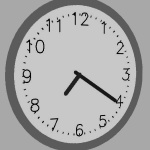

07:[21]


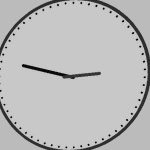

02:[48]


In [2]:
IMG_SIZE = 150

training = 80000
testing = 15000
# training = 80
# testing = 15

train_imgs, train_hours, train_minutes = load_batch(
    np.arange(training), len(np.arange(training)), IMG_SIZE)
test_imgs, test_hours, test_minutes = load_batch(
    (np.arange(testing) + training), len((np.arange(testing) + training)), IMG_SIZE)

# Verify that dataset labels are correct
cv.imwrite("temp/sample_train.jpg", train_imgs[0])
cv.imwrite("temp/sample_test.jpg", test_imgs[0])
display(Image(filename="temp/sample_train.jpg"))
hour, minute = get_time(train_hours[0][0], train_minutes[0])
print(str(hour).zfill(2)+":"+str(minute).zfill(2))
display(Image(filename="temp/sample_test.jpg"))
hour, minute = get_time(test_hours[0][0], test_minutes[0])
print(str(hour).zfill(2)+":"+str(minute).zfill(2))

assert pd.api.types.is_integer_dtype(train_hours)
assert pd.api.types.is_float_dtype(train_minutes)
assert pd.api.types.is_integer_dtype(test_hours)
assert pd.api.types.is_float_dtype(test_minutes)
assert not np.any(np.isnan(train_hours))
assert not np.any(np.isnan(train_minutes))
assert not np.any(np.isnan(test_hours))
assert not np.any(np.isnan(test_minutes))


Train Model

In [4]:
# Hyperparameters

# CNN
CNN_KERNEL_SIZE = [7, 5, 3]
CNN_STRIDES = [4, 2, 1]
CNN_FILTERS = [128, 192, 256]

# Pooling
POOL_SIZE = [(2, 2)]
POOL_STRIDES = [2]

# Dropout
DROPOUT_P = [0.1]

# Fully Connected (Hour)
HOUR_UNITS = [512]

# Fully Connected (Minute)
MINUTE_UNITS = [512]

# Adam optimizer
LEARNING_RATE = 0.00025

BATCH_SIZE = 64
NUM_EPOCHS = 10

model = load_model(IMG_SIZE, CNN_KERNEL_SIZE, CNN_STRIDES, CNN_FILTERS,
                   POOL_SIZE, POOL_STRIDES, DROPOUT_P, HOUR_UNITS, MINUTE_UNITS)

losses = {
    "hour": "sparse_categorical_crossentropy",
    "minute": "mse"
}
lossWeights = {"hour": 1.0, "minute": 1.0}
metrics = {"hour": ['accuracy'], "minute": ['mse']}

# losses = {
#     "hour": "sparse_categorical_crossentropy",
#     "minute": "sparse_categorical_crossentropy"
# }
# lossWeights = {"hour": 1.0, "minute": 1.0}
# metrics = {"hour": ['accuracy'], "minute": ['accuracy']}

opt = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, decay=LEARNING_RATE/NUM_EPOCHS)

model.compile(loss=losses, loss_weights=lossWeights,
              optimizer=opt, metrics=metrics)

print(model.summary())

history = model.fit(x=train_imgs, y={"hour": train_hours.astype(int), "minute": train_minutes.astype(float)}, validation_data=(
    test_imgs, {"hour": test_hours.astype(int), "minute": test_minutes.astype(float)}), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# history = model.fit(x=train_imgs, y={"hour": train_hours.astype(int), "minute": train_minutes.astype(float)}, validation_data=(
#     test_imgs, {"hour": test_hours.astype(int), "minute": test_minutes.astype(int)}), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)

model.save('model/my_model')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 38, 38, 128)  6400        ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 19, 19, 192)  614592      ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 19, 19, 256)  442624      ['conv2d_4[0][0]']         

Plot Training Information

dict_keys(['loss', 'hour_loss', 'minute_loss', 'hour_accuracy', 'minute_accuracy', 'val_loss', 'val_hour_loss', 'val_minute_loss', 'val_hour_accuracy', 'val_minute_accuracy'])


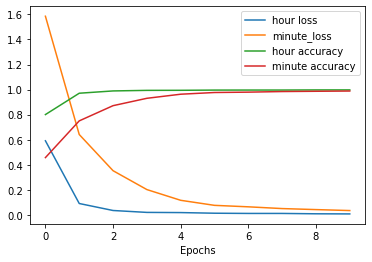

In [6]:
print(history.history.keys())
pyplot.plot(history.history['hour_loss'], label="hour loss")
pyplot.plot(history.history['minute_loss'], label="minute_loss")
pyplot.plot(history.history['hour_accuracy'], label="hour accuracy")
pyplot.plot(history.history['minute_accuracy'], label="minute accuracy")
# pyplot.plot(history.history['minute_mse'], label="minute mse")
pyplot.xlabel("Epochs")
pyplot.legend(loc="upper right")
pyplot.show()

Load Model

In [ ]:
model = keras.models.load_model('model/my_model')

Predict

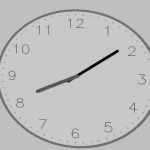

Predicted:  08:1.000000004109785


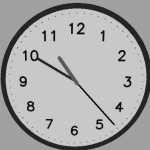

Predicted:  10:1.0000008393437838


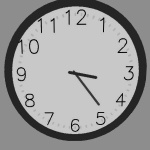

Predicted:  03:1.0000124694543047


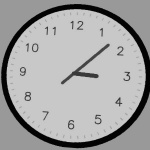

Predicted:  03:1.0000000000001972


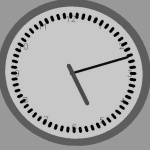

Predicted:  05:1.00000000042987


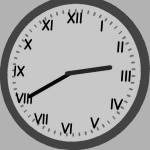

Predicted:  02:1.0000000000048732


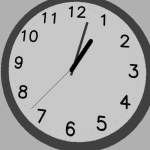

Predicted:  01:1.0676430314779282


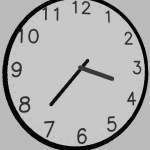

Predicted:  03:1.0000000002127094


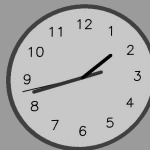

Predicted:  01:1.0000000000004114


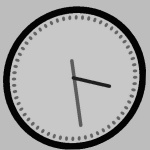

Predicted:  03:1.000000000000012


In [7]:
IMG_SIZE = 150

idx = training + testing
for i in range(10):
    img = cv.imread("images/" + str(idx+i) + ".jpg")
    img = preprocess(img, IMG_SIZE)
    cv.imwrite("temp/" + str(idx+i) + ".jpg", img)
    display(Image(filename="temp/" + str(idx+i) + ".jpg"))
    hour, minute = model.predict(np.array([img]))
    hour = np.argmax(hour)
    minute = (minute[0][0])
    hour, minute = get_time(hour, minute)
    print("Predicted: ", str(hour).zfill(2)+":"+str(minute).zfill(2))